In [10]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [11]:
# Load data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')



In [12]:
def create_customer_features(customers, transactions):
    tx_features = transactions.groupby('CustomerID').agg({
        'TotalValue': ['sum', 'mean', 'count'],
        'Quantity': ['sum', 'mean']
    }).fillna(0)
    tx_features.columns = ['total_spent', 'avg_transaction', 'transaction_count', 'total_quantity', 'avg_quantity']
    
    latest_date = pd.to_datetime(transactions['TransactionDate']).max()
    last_purchase = transactions.groupby('CustomerID')['TransactionDate'].max()
    recency = (latest_date - pd.to_datetime(last_purchase)).dt.days
    
    features = pd.DataFrame(index=customers['CustomerID'])
    features = features.join(tx_features)
    features['recency'] = recency
    features = features.fillna(0)
    
    return features



In [13]:
# Create and scale features
features = create_customer_features(customers, transactions)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


# Clustering evaluation
db_scores = []
silhouette_scores = []
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_features)
    
    db_scores.append(davies_bouldin_score(scaled_features, labels))
    silhouette_scores.append(silhouette_score(scaled_features, labels))
    inertias.append(kmeans.inertia_)



In [15]:
# Optimal clustering
optimal_k = k_range[np.argmin(db_scores)]
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = final_kmeans.fit_predict(scaled_features)

# Add cluster labels
features['Cluster'] = clusters




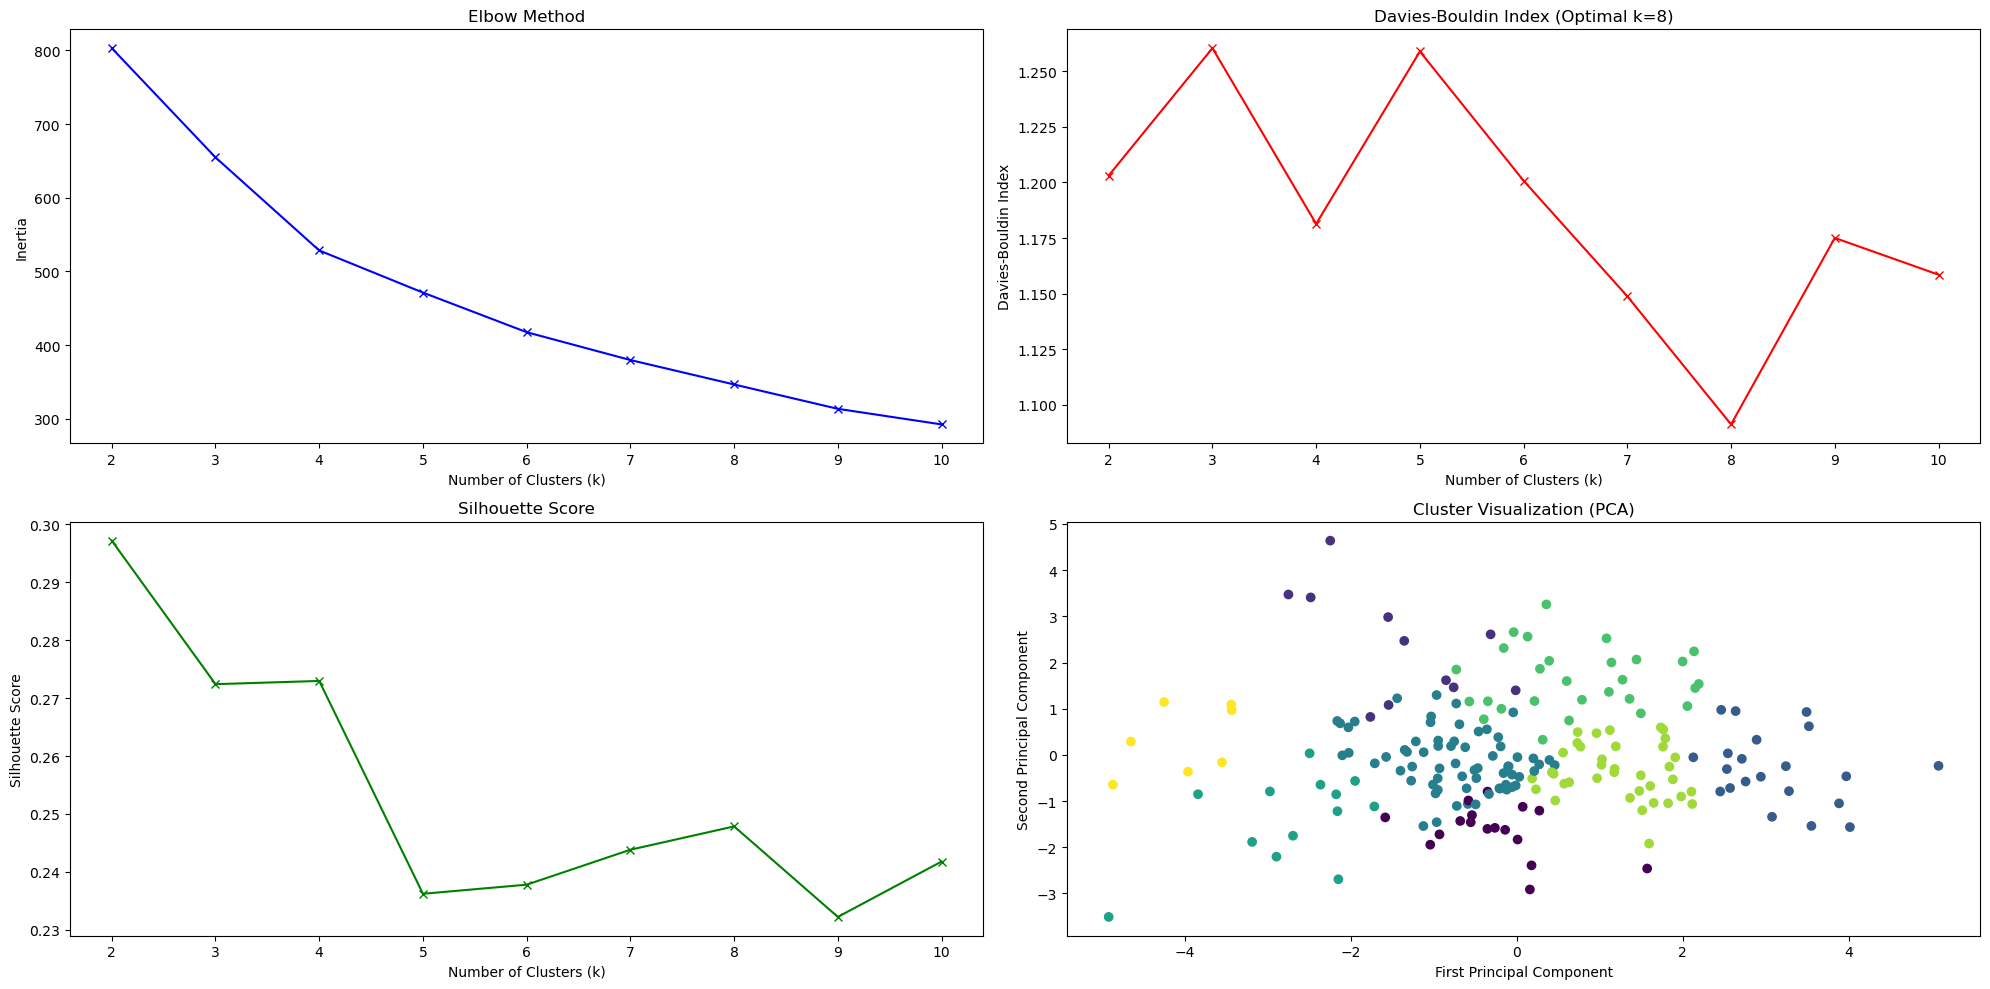


Clustering Metrics:
Number of clusters: 8
Davies-Bouldin Index: 1.091
Silhouette Score: 0.297

Cluster Characteristics:
        total_spent       avg_transaction transaction_count recency
               mean count            mean              mean    mean
Cluster                                                            
0           3134.06    17          451.32              7.06   70.35
1           1852.05    11          767.75              2.55  227.91
2           6780.82    21          816.32              8.43   36.57
3           2476.07    66          631.42              3.98   45.73
4            867.35    13          283.98              2.85   65.38
5           4379.11    28         1062.35              4.18   88.50
6           4694.47    37          700.09              6.76   56.70
7            420.01     7          364.78              1.14  255.57


In [17]:
# Visualizations
plt.figure(figsize=(20, 10))

# Plot 1: Elbow curve
plt.subplot(2, 2, 1)
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot 2: DB Index
plt.subplot(2, 2, 2)
plt.plot(k_range, db_scores, 'rx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title(f'Davies-Bouldin Index (Optimal k={optimal_k})')

# Plot 3: Silhouette Score
plt.subplot(2, 2, 3)
plt.plot(k_range, silhouette_scores, 'gx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

# Plot 4: PCA visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
plt.subplot(2, 2, 4)
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=clusters, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Cluster Visualization (PCA)')

plt.tight_layout()
plt.show()

# Print metrics
print(f"\nClustering Metrics:")
print(f"Number of clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {min(db_scores):.3f}")
print(f"Silhouette Score: {max(silhouette_scores):.3f}")

# Cluster characteristics
print("\nCluster Characteristics:")
cluster_stats = features.groupby('Cluster').agg({
    'total_spent': ['mean', 'count'],
    'avg_transaction': 'mean',
    'transaction_count': 'mean',
    'recency': 'mean'
}).round(2)

print(cluster_stats)

In [25]:
def generate_clustering_report():
   
   # Generate report content
   report_content = f""" # Customer Segmentation Report

* Number of clusters formed: {optimal_k}
* Davies-Bouldin Index: {min(db_scores):.3f}
* Silhouette Score: {max(silhouette_scores):.3f}

"""

   # Save report
   with open('clustering_report.md', 'w') as f:
       f.write(report_content)

# Execute
generate_clustering_report()